# Исследование результатов А/В-теста интернет магазина

В ходе данного исследования необходимо приоритизировать гипотезы, подготовленные для увеличения выручки крупного интернет магазина, запустить А/В тест и проанализировать результаты.

Для выполнения задачи предоставлены следующие датасеты:
- список гипотез;
- таблица заказов интернет магазина с разбивкой по группам;
- таблица с указанием количества пользователей по датам с разбивкой по группам.

## Изучение общей информации

Импортируем все необходимые для работы библиотеки.

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import datetime as dt

from matplotlib import pyplot as plt

Загрузим датасеты. Для удоства работы названия столбцов приведем к нижнему регистру. Столбцы с датами приведем к типу `datetime`

In [2]:
try:
    hypothesis = pd.read_csv('/datasets/hypothesis.csv')
except:
    hypothesis = pd.read_csv('https://code.s3.yandex.net/datasets/hypothesis.csv')
    
hypothesis.columns = hypothesis.columns.str.lower()
hypothesis

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


**Описание данных:**
- `Hypothesis` — краткое описание гипотезы;
- `Reach` — охват пользователей по 10-балльной шкале;
- `Impact` — влияние на пользователей по 10-балльной шкале;
- `Confidence` — уверенность в гипотезе по 10-балльной шкале;
- `Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка 

In [3]:
try:
    orders = pd.read_csv('/datasets/orders.csv')
except:
    orders = pd.read_csv('orders.csv')

orders

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A
1195,1947021204,1614305549,2019-08-14,100,A


In [4]:
orders['date'] = pd.to_datetime(orders['date'], format='%Y-%m-%d')

**Описание данных:**
- `transactionId` — идентификатор заказа;
- `visitorId` — идентификатор пользователя, совершившего заказ;
- `date` — дата, когда был совершён заказ;
- `revenue` — выручка заказа;
- `group` — группа A/B-теста, в которую попал заказ

In [5]:
try:
    visitors = pd.read_csv('/datasets/visitors.csv')
except:
    visitors = pd.read_csv('visitors.csv')

visitors

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
...,...,...,...
57,2019-08-27,B,720
58,2019-08-28,B,654
59,2019-08-29,B,531
60,2019-08-30,B,490


In [6]:
visitors['date'] = pd.to_datetime(visitors['date'], format='%Y-%m-%d')

**Описание данных:**
- `date` — дата;
- `group` — группа A/B-теста;
- `visitors` — количество пользователей в указанную дату в указанной группе A/B-теста

Проверим качество распределения пользователей по группам. Сгруппируем заказы по пользователям и посчитаем для каждого количество уникальных значений присвоенной группы. Выведем количество пользователей которые попали в 2 группы одновременно.

In [7]:
orders.groupby('visitorId', as_index=False)['group'].nunique().query('group > 1')['visitorId'].count()

58

Исключим таких пользователей, чтобы не искажать результаты теста.

In [8]:
orders = orders[~(orders['visitorId'].isin(
    orders.groupby('visitorId', as_index=False)['group']
    .nunique().query('group > 1')['visitorId']))]

Определим даты начала и окончания А/В-теста.

In [9]:
print(f'''Дата начала А/В-теста: {orders.date.min().date()}
Дата окончания А/В-теста {orders.date.max().date()}''')

Дата начала А/В-теста: 2019-08-01
Дата окончания А/В-теста 2019-08-31


Найдем суммарное количество уникальных пользователей, сделавших заказ для каждой группы.

In [10]:
orders.groupby('group')['visitorId'].nunique()

group
A    445
B    528
Name: visitorId, dtype: int64

In [11]:
print('Разница между группами составляет',\
      abs(
    round(
        ((orders.groupby('group')['visitorId'].nunique()[0]/orders.groupby('group')['visitorId'].nunique()[1]) - 1), 4
    )))

Разница между группами составляет 0.1572


А/В-тест парный. В группе А - 445 пользователей, в группе В - 528 пользователей. Разница между группами составляет 16%.

Проверим данные на наличие пропусков и дубликатов.

In [12]:
dict = {'hypothesis':hypothesis, 'orders':orders, 'visitors':visitors}
for i in dict:
    print(i)
    print('')
    print('Количество дубликатов строк:', dict[i].duplicated().sum())
    print('')
    print('Количество пропусков по столбцам:')
    print(dict[i].isna().sum())
    print('-'*30)

hypothesis

Количество дубликатов строк: 0

Количество пропусков по столбцам:
hypothesis    0
reach         0
impact        0
confidence    0
efforts       0
dtype: int64
------------------------------
orders

Количество дубликатов строк: 0

Количество пропусков по столбцам:
transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64
------------------------------
visitors

Количество дубликатов строк: 0

Количество пропусков по столбцам:
date        0
group       0
visitors    0
dtype: int64
------------------------------


Пропуски и дубликаты строк в данных отсутствуют.

## Приоритизация гипотез

In [13]:
hypothesis

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


Применим фреймворки `ICE` и `RICE` для приоритизации гипотез для этого добавим в таблицу столбцы с рассчитанными показателями.

Показатели фреймворков рассчитываются по следующим компонентам:

* `Reach` — скольких пользователей затронет изменение, которое вы хотите внести;
* `Impact` — насколько сильно изменение повлияет на пользователей, их опыт и удовлетворение от продукта;
* `Confidence` — насколько вы уверены, что это изменение повлияет на пользователей именно так; 
* `Efforts` — сколько стоит протестировать эту гипотезу.

В фреймворке `ICE` задействованы компоненты Impact, Confidence, Efforts. Фреймворк `RICE` дополнительно к ним задействует Reach.

In [14]:
hypothesis['ICE'] = round((hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts'], 2)
hypothesis['RICE'] = round((hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts'], 2)

In [15]:
pd.set_option('max_colwidth', 200) # Для полного отображения текста в ячейках установим параметры set_option

In [16]:
hypothesis[['hypothesis', 'RICE', 'ICE']].sort_values('RICE', ascending=False)

,hypothesis,RICE,ICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0,11.20
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0,7.00
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0,13.33
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0,8.00
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2,16.20
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0,1.12
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0,2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0,1.33
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0,1.00


Для оценки гипотезы одновременно по двум параметрам создадим столбец `weight`, где укажем сумму отношений показателей фреймворков для каждой гипотезы к суммарному количеству очков каждого фреймворка. По нему отсортируем данные и определим приоритет гипотез с учетом двух фреймворков одновременно.

In [17]:
hypothesis['weight'] = round((hypothesis['RICE']/hypothesis['RICE'].sum() + (hypothesis['ICE']/hypothesis['ICE'].sum())), 2)
hypothesis.sort_values('weight', ascending=False)

,hypothesis,reach,impact,confidence,efforts,ICE,RICE,weight
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20,112.0,0.58
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33,40.0,0.36
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20,16.2,0.32
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00,56.0,0.31
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00,40.0,0.27
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00,4.0,0.05
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12,9.0,0.05
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33,4.0,0.04
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00,3.0,0.03


По параметрам фреймворка ICE наиболее приоритетными являются гипотезы с индексами 8, 0, 7 и 6.

По параметрам фреймворка RICE приоритетны гипотезы с индексами 7, 2, 0, 6. Введение параметра, который зависит от охвата аудитории, значительно повлияло на приоритет гипотез.

**С учетом параметров фреймворков ICE и RICE для проверки выберем 2 гипотезы:**
- Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
- Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей

In [18]:
pd.set_option('max_colwidth', 50) # Вернем исходные параметры отображения ячеек

## Анализ A/B-теста

Проанализируем результаты проведенного A/B-теста. Для этого создадим датафрейм, который будет содержать кумулятивные показатели с разбивкой по группам.

In [19]:
# создадим датафрейм с указанием количества посетителей группы А за каждый день
visitors_a_daily = visitors.query('group == "A"')[['date', 'visitors']]
visitors_a_daily.columns = ['date', 'vis_per_date_a']

# создадим датафрейм с указанием количества посетителей группы А за каждый день с накоплением
visitors_a_cumulative = (
    visitors_a_daily.apply(lambda x: visitors_a_daily[visitors_a_daily['date'] <= x['date']]
                           .agg({'date':'max', 'vis_per_date_a':'sum'}), axis=1)
)
visitors_a_cumulative.columns = ['date', 'vis_cumulative_a']

# создадим датафрейм с указанием количества посетителей группы B за каждый день
visitors_b_daily = visitors.query('group == "B"')[['date', 'visitors']]
visitors_b_daily.columns = ['date', 'vis_per_date_b']

# создадим датафрейм с указанием количества посетителей группы А за каждый день с накоплением
visitors_b_cumulative = (
    visitors_b_daily.apply(lambda x: visitors_b_daily[visitors_b_daily['date'] <= x['date']]
                           .agg({'date':'max', 'vis_per_date_b':'sum'}), axis=1)
)
visitors_b_cumulative.columns = ['date', 'vis_cumulative_b']


# создадим датафрейм с указанием количества заказов группы А за каждый день
orders_a_daily = (
    orders[orders['group'] == "A"][['transactionId', 'visitorId', 'date', 'revenue']]
    .groupby('date', as_index=False).agg({'transactionId': 'nunique', 'revenue':'sum'})
    .sort_values('date')
)
orders_a_daily.columns = ['date', 'ord_per_date_a', 'rev_per_date_a']

# создадим датафрейм с указанием количества заказов группы А за каждый день с накоплением
orders_a_cumulative = (
    orders_a_daily.apply(lambda x: orders_a_daily[orders_a_daily['date'] <= x['date']]
                        .agg({'date':'max', 'ord_per_date_a':'sum', 'rev_per_date_a':'sum'}), axis=1)
)
orders_a_cumulative.columns = ['date', 'ord_a_cumulative', 'rev_a_cumulative']

# создадим датафрейм с указанием количества заказов группы B за каждый день
orders_b_daily = (
    orders[orders['group'] == "B"][['transactionId', 'visitorId', 'date', 'revenue']]
    .groupby('date', as_index=False).agg({'transactionId': 'nunique', 'revenue':'sum'})
    .sort_values('date')
)
orders_b_daily.columns = ['date', 'ord_per_date_b', 'rev_per_date_b']

# создадим датафрейм с указанием количества заказов группы B за каждый день с накоплением
orders_b_cumulative = (
    orders_b_daily.apply(lambda x: orders_b_daily[orders_b_daily['date'] <= x['date']]
                        .agg({'date':'max', 'ord_per_date_b':'sum', 'rev_per_date_b':'sum'}), axis=1)
)
orders_b_cumulative.columns = ['date', 'ord_b_cumulative', 'rev_b_cumulative']

# создадим итоговую таблицу путем объединения всех созданных ранее
data = (
    orders_a_daily.merge(orders_b_daily, left_on='date', right_on='date', how='left')
    .merge(orders_a_cumulative, left_on='date', right_on='date', how='left')
    .merge(orders_b_cumulative, left_on='date', right_on='date', how='left')
    .merge(visitors_a_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_b_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_a_cumulative, left_on='date', right_on='date', how='left')
    .merge(visitors_b_cumulative, left_on='date', right_on='date', how='left')
)

data.head()

,date,ord_per_date_a,rev_per_date_a,ord_per_date_b,rev_per_date_b,ord_a_cumulative,rev_a_cumulative,ord_b_cumulative,rev_b_cumulative,vis_per_date_a,vis_per_date_b,vis_cumulative_a,vis_cumulative_b
0,2019-08-01,23,142779,17,59758,23,142779,17,59758,719,713,719,713
1,2019-08-02,19,91602,23,162043,42,234381,40,221801,619,581,1338,1294
2,2019-08-03,24,112473,14,67049,66,346854,54,288850,507,509,1845,1803
3,2019-08-04,11,41176,14,96890,77,388030,68,385740,717,770,2562,2573
4,2019-08-05,22,86383,21,89908,99,474413,89,475648,756,707,3318,3280


### Анализ результатов А/B-теста

Построим и проанализируем **график кумулятивной выручки по группам.**

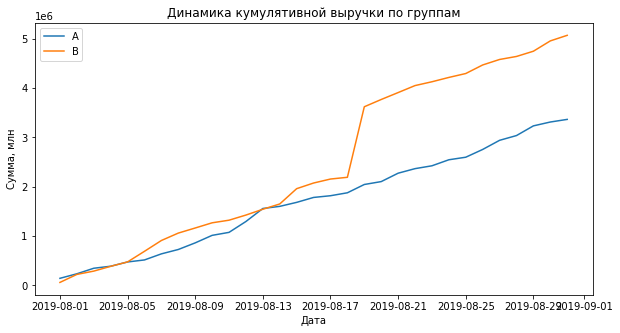

In [20]:
plt.figure(figsize =(10, 5)) 
plt.plot(data.date, data.rev_a_cumulative, label='A')
plt.plot(data.date, data.rev_b_cumulative, label='B')
plt.title('Динамика кумулятивной выручки по группам')
plt.xlabel('Дата')
plt.ylabel('Сумма, млн')
plt.legend()
plt.show()

**Вывод:** после середины теста группа B резко вырвалась вперед и продолжала лидировать с одинаковым отрывом от группы А до конца теста. Возможно это произошло из-за присутствия в данных аномально дорогих заказов.

Построим и проанализируем **график кумулятивного среднего чека по группам.**

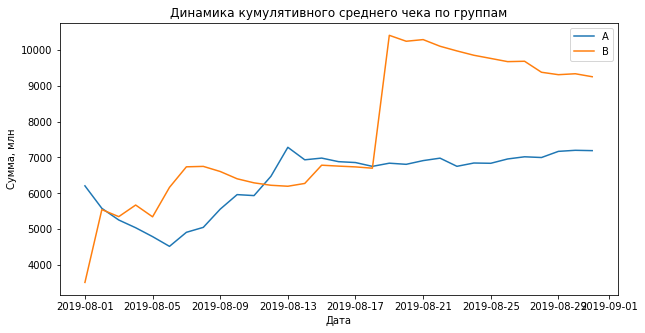

In [21]:
plt.figure(figsize=(10, 5)) 
plt.plot(data.date, data.rev_a_cumulative/data.ord_a_cumulative, label='A')
plt.plot(data.date, data.rev_b_cumulative/data.ord_b_cumulative, label='B')
plt.title('Динамика кумулятивного среднего чека по группам')
plt.xlabel('Дата')
plt.ylabel('Сумма, млн')
plt.legend()
plt.show()

**Вывод:** значение кумулятивного среднего чека по сегментам сильно колеблется до середины теста. После середины кумулятивный средний чек группы В резко значительно вырос, что также подтверждает наличие аномально дорогих заказов в данных.

Построим и проанализируем **график изменения кумулятивного среднего чека группы B к группе A.**

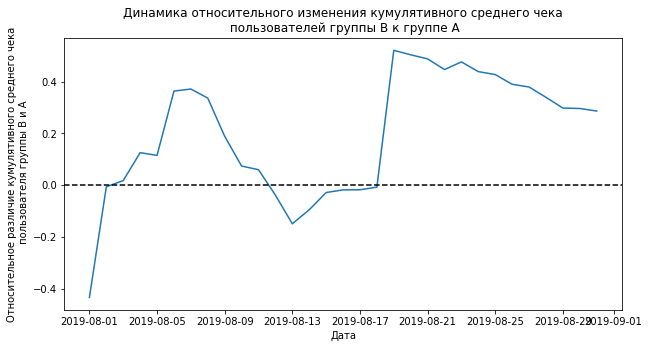

In [22]:
plt.figure(figsize=(10, 5)) 
plt.plot(data.date, ((data.rev_b_cumulative/data.ord_b_cumulative) / (data.rev_a_cumulative/data.ord_a_cumulative)) - 1, label='A')
plt.title('Динамика относительного изменения кумулятивного среднего чека\n пользователей группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Относительное различие кумулятивного среднего чека\n пользователя группы B и A')
plt.axhline(y=0, color='black', linestyle='--')
plt.show()

**Вывод:** на графике видны значительные колебания. Результаты теста сильно менялись, поэтому какие-либо выводы по данному графику сделать невозможно.

Построим и проанализируем **график среднего кумулятивного количества заказов на посетителя по группам.**

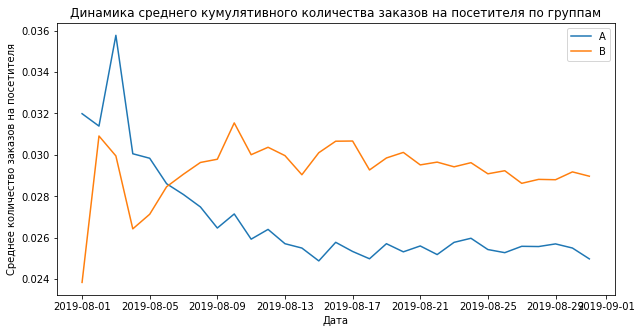

In [23]:
plt.figure(figsize=(10, 5)) 
plt.plot(data.date, data.ord_a_cumulative / data.vis_cumulative_a, label='A')
plt.plot(data.date, data.ord_b_cumulative / data.vis_cumulative_b, label='B')
plt.title('Динамика среднего кумулятивного количества заказов на посетителя по группам')
plt.xlabel('Дата')
plt.ylabel('Среднее количество заказов на посетителя')
plt.legend()
plt.show()

**Вывод:** результаты сильно колебались в начале теста, после установились на стабильном уровне. Динамика среднего кумулятивного количества заказов на посетителя группы В выше, чем группы А, что в целом говорит о том, что в группе В стабильно больше заказов на 1 пользователя, чем в группе А.

Построим и проанализируем **график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A.**

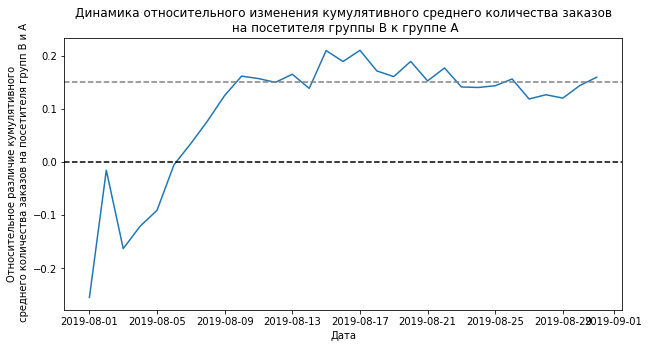

In [24]:
plt.figure(figsize=(10, 5)) 
plt.plot(data.date, ((data.ord_b_cumulative / data.vis_cumulative_b) / (data.ord_a_cumulative / data.vis_cumulative_a) - 1),\
         label='A')
plt.title('Динамика относительного изменения кумулятивного среднего количества заказов\n на посетителя группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Относительное различие кумулятивного\n среднего количества заказов на посетителя групп B и A')
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=.15, color='grey', linestyle='--')
plt.show()

**Вывод:** по графику заметен значительный рост относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A в начале теста, который далее колеблется около значения 0.15. В группе В в среднем на 15% больше заказов на посетителя в день, чем в группе А.

### Выявление аномальных значений

Построим **точечный график количества заказов по пользователям.**

Для этого создадим датафрейм с рассчитанным количеством заказов для каждого пользователя.

In [25]:
ord_per_user = orders.groupby('visitorId').agg({'transactionId':'count', 'group':'max'})
ord_per_user.columns = ['order_cnt', 'group']
ord_per_user

,order_cnt,group
visitorId,,
5114589,1,B
6958315,1,B
11685486,1,A
39475350,1,B
47206413,1,B
...,...,...
4259830713,1,A
4278982564,1,A
4279090005,1,B


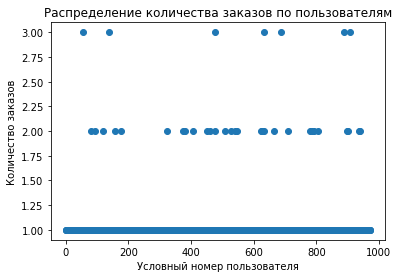

In [26]:
plt.scatter(pd.Series(range(len(ord_per_user))), ord_per_user['order_cnt'])
plt.title('Распределение количества заказов по пользователям')
plt.xlabel('Условный номер пользователя')
plt.ylabel('Количество заказов')
plt.show()

**Вывод:** большинство пользователей сделало 1 заказ. Пользователей с количеством заказов 2 и 3 значительно меньше.

Посчитаем 95-й и 99-й перцентили количества заказов на пользователя.

In [27]:
np.percentile(ord_per_user['order_cnt'], [95, 99])

array([1., 2.])

Отметим, что 5% пользователей сделали более 1 заказа и 1% пользователей сделали более 2 заказов. На основании этого будем считать количество заказов на одного пользователя более 2 аномальным значением.

Построим **точечный график стоимостей заказов.**

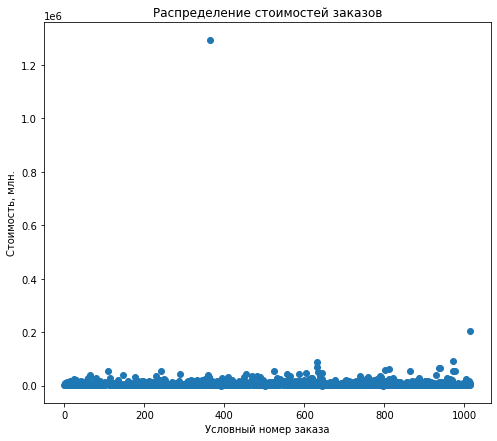

In [28]:
plt.figure(figsize=(8, 7)) 
plt.scatter(pd.Series(range(len(orders))), orders.revenue)
plt.title('Распределение стоимостей заказов')
plt.xlabel('Условный номер заказа')
plt.ylabel('Стоимость, млн.')
plt.show()

Из-за двух очень крупных заказов масштаб графика установился очень большим. Посмотрим более делатьно на заказы стоимостью от 0 до 100000.

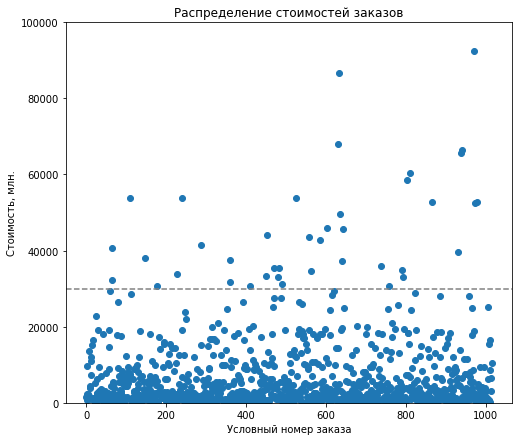

In [29]:
plt.figure(figsize=(8, 7)) 
plt.scatter(pd.Series(range(len(orders))), orders.revenue)
plt.title('Распределение стоимостей заказов')
plt.xlabel('Условный номер заказа')
plt.ylabel('Стоимость, млн.')
plt.axhline(y=30000, color='grey', linestyle='--')
plt.ylim(0, 100000)
plt.show()

**Вывод:** большинство заказов имеет стоимость не более 30000. 
    
Посчитаем 95-й и 99-й перцентили стоимости заказов.

In [30]:
np.percentile(orders.revenue, [95, 99])

array([26785., 53904.])

Отметим, что 5% заказов имеют стоимость более 26785 и 1% заказов имеют стоимость более 53904. На основании этого будем считать сумму заказа более 26785 аномальным значением.

### Проверка гипотез

В ходе проверки гипотез будем искать различия в следующих метриках:
- среднее число заказов на посетителя
- средний чек посетителя

Установим нулевую и альтернативную гипотезы:

*Н0 - Нет различий между группами А и В.\
Н1 - Есть различия между группами А и В.*

По отображенным выше диаграммам рассеивания числа заказов на посетителя и суммы заказа видно, что большинство точек расположено у минимальных отметок и чем больше значение переменной, тем меньше количество точек на графике. В таком случае, поскольку рассматриваемые переменные не распределены нормально и имеют много выбросов, для проверки гипотез будем использовать непараметрический тест Уилкоксона-Манна-Уитни.

Для статистических тестов зададим параметр статистической значимости *alpha* равным *0.05*.

Создадим для каждой из групп датасет, в котором будет указано количество заказов для каждого пользователя. Для пользователей, которые ничего не заказали, укажем ноль.

In [31]:
# соединим объект с данными о количестве заказов бользователей и пустой объект, 
# в котором количество нулей будет равно количеству пользователей, не сделавших заказ
sample_a = (pd.concat(
    [ord_per_user.query('group == "A"')['order_cnt'],
     pd.Series(0, index=np.arange(
         data.vis_per_date_a.sum() - len(ord_per_user.query('group == "A"')['order_cnt'])), name='orders')],
    axis=0))

sample_b = (pd.concat(
    [ord_per_user.query('group == "B"')['order_cnt'],
     pd.Series(0, index=np.arange(
         data.vis_per_date_b.sum() - len(ord_per_user.query('group == "B"')['order_cnt'])), name='orders')],
    axis=0))

**Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным.**

In [32]:
print('P-value:', '{0:.3f}'.format(stats.mannwhitneyu(sample_a,sample_b)[1]))
print('Разница между средним количеством заказов группы В и средним группы А:', '{0:.3f}'
      .format(((sample_b.mean() / sample_a.mean()) - 1)))

P-value: 0.011
Разница между средним количеством заказов группы В и средним группы А: 0.160


Результаты показывают, что имеются значимые различия между группами по «сырым» данным, т.к. p-value (0.011) ниже значения alpha (0.05). В группе B среднее количество заказов на пользователя на 16% больше, чем в группе A.

**Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным.**

In [33]:
print('P-value:', '{0:.3f}'.format(stats.mannwhitneyu(
        orders.query('group == "A"')['revenue'],
        orders.query('group == "B"')['revenue']
)[1]))

print('Разница между средним чеком группы В и средним чеком группы А:', '{0:.3f}'.format(
        (orders.query('group == "B"')['revenue'].mean() / orders.query('group == "A"')['revenue'].mean()) - 1
))

P-value: 0.829
Разница между средним чеком группы В и средним чеком группы А: 0.287


Результаты показывают, что значимых различий между группами по «сырым» данным нет, т.к. p-value (0.829) выше значения alpha (0.05). В группе B средний чек пользователя на 28.7% больше, чем в группе A.

Для того, чтобы проверить гипотезы по «очищеным» данным отберем id пользователей, совершивших более 2 заказов и id пользователей, заказавших на сумму более 26785. Объединим найденных (аномальных) пользователей в один датафрейм.

In [34]:
# найдем пользователей с количеством заказов больше 2
us_many_ord = orders.groupby('visitorId', as_index=False)['transactionId'].count()
us_many_ord = us_many_ord[us_many_ord['transactionId'] > np.percentile(ord_per_user['order_cnt'], 99)]['visitorId']

# найдем пользователей с суммой заказа больше 26785
us_exp_ord = orders[orders['revenue'] > np.percentile(orders['revenue'], 95)]['visitorId']

# объединим найденных пользователей в один объект
anomal_users = pd.concat([us_many_ord, us_exp_ord], axis=0).drop_duplicates()

Найдем количество анолмальных пользователей. Также посмотрим, какая доля аномальных пользователей относительно всех пользователей, сделавших заказ.

In [35]:
print('Число аномальных пользователей:', len(anomal_users))
print('Доля аномальных пользователей относительно всех пользователей, сделавших заказ:',\
     round(len(anomal_users) / orders.visitorId.nunique(), 2))

Число аномальных пользователей: 58
Доля аномальных пользователей относительно всех пользователей, сделавших заказ: 0.06


**Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным.**

In [36]:
print('P-value:', '{0:.3f}'.format(stats.mannwhitneyu(
    sample_a[~(sample_a.index.isin(anomal_users))],sample_b[~(sample_b.index.isin(anomal_users))]
)[1]))

print('Разница между средним количеством заказов группы В и средним группы А:', '{0:.3f}'.format(((
    sample_b[~(sample_b.index.isin(anomal_users))].mean() / sample_a[~(sample_a.index.isin(anomal_users))].mean()
) - 1)))

P-value: 0.012
Разница между средним количеством заказов группы В и средним группы А: 0.182


Результаты показывают, что имеются значимые различия между группами по «очищеным» данным, т.к. p-value (0.012) ниже значения alpha (0.05). В группе B среднее количество заказов на пользователя на 18.2% больше, чем в группе A.

**Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным.**

In [37]:
print('P-value:', '{0:.3f}'.format(stats.mannwhitneyu(
        orders[(orders['group'] == "A") & ~(orders['visitorId'].isin(anomal_users))]['revenue'],
        orders[(orders['group'] == "B") & ~(orders['visitorId'].isin(anomal_users))]['revenue']
)[1]))

print('Разница между средним количеством заказов группы В и средним группы А:', '{0:.3f}'.format(
        (orders[(orders['group'] == "B") & ~(orders['visitorId'].isin(anomal_users))]['revenue'].mean() /
         orders[(orders['group'] == "A") & ~(orders['visitorId'].isin(anomal_users))]['revenue'].mean()) - 1
))

P-value: 0.646
Разница между средним количеством заказов группы В и средним группы А: -0.048


Результаты показывают, что значимых различий между группами по «очищенным» данным нет, т.к. p-value (0.829) выше значения alpha (0.05). В группе А средний чек пользователя на 4.8% больше, чем в группе В.

Убедимся в том, что, если исключить заказы с аномальными значениями стоимости из данных A/B-теста, динамика изменения кумулятивного среднего чека группы B к группе A к установилась на одном уровне. Для этого воспользуемся ранее написанным кодом и создадим датафрейм `filt_data`, при создании которого не будем учитывать заказы стоимостью более 26785.

In [38]:
filt_orders = orders[~(orders['visitorId'].isin(anomal_users))].copy()

# создадим датафрейм с указанием количества посетителей группы А за каждый день
visitors_a_daily = visitors.query('group == "A"')[['date', 'visitors']]
visitors_a_daily.columns = ['date', 'vis_per_date_a']
# создадим датафрейм с указанием количества посетителей группы А за каждый день с накоплением
visitors_a_cumulative = (
    visitors_a_daily.apply(lambda x: visitors_a_daily[visitors_a_daily['date'] <= x['date']]
                           .agg({'date':'max', 'vis_per_date_a':'sum'}), axis=1)
)
visitors_a_cumulative.columns = ['date', 'vis_cumulative_a']
# создадим датафрейм с указанием количества посетителей группы B за каждый день
visitors_b_daily = visitors.query('group == "B"')[['date', 'visitors']]
visitors_b_daily.columns = ['date', 'vis_per_date_b']
# создадим датафрейм с указанием количества посетителей группы А за каждый день с накоплением
visitors_b_cumulative = (
    visitors_b_daily.apply(lambda x: visitors_b_daily[visitors_b_daily['date'] <= x['date']]
                           .agg({'date':'max', 'vis_per_date_b':'sum'}), axis=1)
)
visitors_b_cumulative.columns = ['date', 'vis_cumulative_b']
# создадим датафрейм с указанием количества заказов группы А за каждый день
orders_a_daily = (
    filt_orders[filt_orders['group'] == "A"][['transactionId', 'visitorId', 'date', 'revenue']]
    .groupby('date', as_index=False).agg({'transactionId': 'nunique', 'revenue':'sum'})
    .sort_values('date')
)
orders_a_daily.columns = ['date', 'ord_per_date_a', 'rev_per_date_a']
# создадим датафрейм с указанием количества заказов группы А за каждый день с накоплением
orders_a_cumulative = (
    orders_a_daily.apply(lambda x: orders_a_daily[orders_a_daily['date'] <= x['date']]
                        .agg({'date':'max', 'ord_per_date_a':'sum', 'rev_per_date_a':'sum'}), axis=1)
)
orders_a_cumulative.columns = ['date', 'ord_a_cumulative', 'rev_a_cumulative']
# создадим датафрейм с указанием количества заказов группы B за каждый день
orders_b_daily = (
    filt_orders[filt_orders['group'] == "B"][['transactionId', 'visitorId', 'date', 'revenue']]
    .groupby('date', as_index=False).agg({'transactionId': 'nunique', 'revenue':'sum'})
    .sort_values('date')
)
orders_b_daily.columns = ['date', 'ord_per_date_b', 'rev_per_date_b']
# создадим датафрейм с указанием количества заказов группы B за каждый день с накоплением
orders_b_cumulative = (
    orders_b_daily.apply(lambda x: orders_b_daily[orders_b_daily['date'] <= x['date']]
                        .agg({'date':'max', 'ord_per_date_b':'sum', 'rev_per_date_b':'sum'}), axis=1)
)
orders_b_cumulative.columns = ['date', 'ord_b_cumulative', 'rev_b_cumulative']
# создадим итоговую таблицу путем объединения всех созданных ранее
filt_data = (
    orders_a_daily.merge(orders_b_daily, left_on='date', right_on='date', how='left')
    .merge(orders_a_cumulative, left_on='date', right_on='date', how='left')
    .merge(orders_b_cumulative, left_on='date', right_on='date', how='left')
    .merge(visitors_a_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_b_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_a_cumulative, left_on='date', right_on='date', how='left')
    .merge(visitors_b_cumulative, left_on='date', right_on='date', how='left')
)

До корректировки отсеивание заказов с аномальным значением стоимости было выполнено по границе более 30000 и график относительного изменения кумулятивного среднего чека группы B к группе A по очищенным данным имел следующий вид:

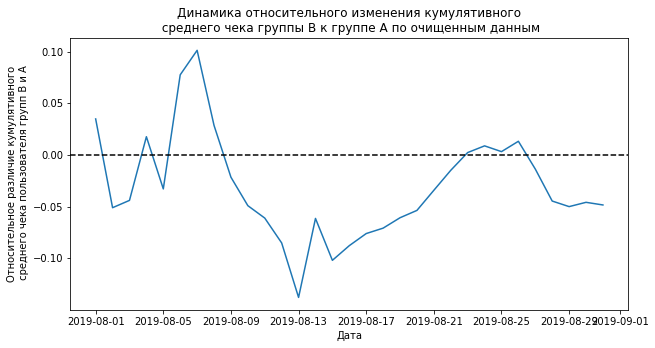

In [39]:
plt.figure(figsize=(10, 5)) 
plt.plot(filt_data.date, ((filt_data.rev_b_cumulative/filt_data.ord_b_cumulative) /
                          (filt_data.rev_a_cumulative/filt_data.ord_a_cumulative)) - 1, label='A')
plt.title('Динамика относительного изменения кумулятивного\n среднего чека группы B к группе A по очищенным данным')
plt.xlabel('Дата')
plt.ylabel('Относительное различие кумулятивного\n среднего чека пользователя групп B и A')
plt.axhline(y=0, color='black', linestyle='--')
plt.show()

Можно было сказать, что относительные изменения установились на одном уровне и принять решение о завершении теста.
    
После установления границы по 95 перцентилю (более 26785) график (тот, что выше комментария) изменился, относительные изменения продолжают колебания.

**Вывод:** динамика относительного изменения кумулятивного среднего чека группы B к группе A на момент окончания теста продолжает колебания в пределах +-5%, в целом можно признать метрику стабилизировавшейся.

### Итоги A/B теста

В результате проверке гипотез установлено следующее:
- по «сырым» данным **в группе B среднее количество заказов на пользователя на 16% больше, чем в группе A**, различия являются статистически значимымыми
-  по «очищеным» данным также **в группе B среднее количество заказов на пользователя на 18.2% больше, чем в группе A**, различия являются статистически значимымыми
- по «сырым» данным **в группе B средний чек пользователя на 28.7% больше, чем в группе A**, однако по причине присутствия аномальных значений эти различия не являются статистически значимыми
- по «очищенным» данным **в группе А средний чек пользователя на 4.8% больше, чем в группе В**, различия не являются статистически значимыми.

Следует отметить, что динамика относительного изменения количества заказов на пользователя группы В к группе А установились на одном уровне. Динамика относительного изменения кумулятивного среднего чека группы B к группе A на момент окончания теста продолжает колебания в пределах +-5%, в целом можно признать метрику стабилизировавшейся.

**На основании результатов теста можно признать победу группы В над группой А**, т.к. в группе B среднее количество заказов на пользователя на 18.2% больше, чем в группе A. Статистически значимые различия в среднем чеке пользователя между группами отсутствуют.

**Цель теста достигнута, все изменения метрик зафиксированы. Тест целесообразно остановить.**

## Общий вывод

В результате данного исследования приоритизированы гипотезы, подготовленные для увеличения выручки крупного интернет магазина, запущен А/В тест и проанализированы его результаты.

Для выполнения задачи предоставлены следующие датасеты:

- список гипотез;
- таблица заказов интернет магазина с разбивкой по группам;
- таблица с указанием количества пользователей по датам с разбивкой по группам.

Пропуски и дубликаты строк в исходных данных отсутствуют.

Длительность теста 1 месяц: с 1 августа 2019г. по 31 августа 2019г.

Разбивка пользователей на группы произведена в неравной пропорции, разница в пользователях, оформивших хотя бы один заказ между группами равна 16% (в группе В пользователей на 16% больше). Выявлено 58 пользователей, состоящие одновременно в двух группах, такие пользователи исключены из анализа, чтобы не искажать результаты теста.

**Приоритизация гипотез**

Для приоритизации гипотез выбраны фреймворки ICE и RICE. ICE определяет приоритет с учетом следующих параметров: насколько сильно изменение повлияет на пользователей, их опыт и удовлетворение от продукта; насколько вы уверены, что это изменение повлияет на пользователей именно так; сколько стоит протестировать эту гипотезу. Фреймворка RICE дополнительно ко всем параметрам фреймворка ICE применяет параметр, учитывающий охват аудитории.

*С учетом параметров одновременно фреймворков ICE и RICE для проверки выбераны 2 гипотезы:*
- Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
- Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей	

**Анализ результатов А/В-теста**

А/В-тест парный. В группе А - 445 пользователей, в группе В - 528 пользователей. Разница между группами составляет 16%.

В ходе проверки гипотез рассмотрены изменения следующих метрик:
- среднее число заказов на посетителя
- средний чек посетителя.

Проверка гипотез выполнялась с помощью непараметрического теста Уилкоксона-Манна-Уитни. Для статистических тестов задан параметр статистической значимости *alpha* равным *0.05*.

При анализе результатов теста выявлено значительное влияние аномальных значений суммы заказа и количества заказов на одного пользователя на показатели теста. Для выполнения анализа без учета аномальных значений установлен порог в количество заказов на кользователя не более 2 и сумму заказа не более 26785.

Число аномальных пользователей, сделавших более 2 заказов или совершивших заказ на сумму более 26758 составляет 58.
Доля аномальных пользователей относительно всех пользователей, сделавших заказ - 0.06%.

Проверка гипотез производилась по «сырым» данным (с учетом аномальных значений суммы заказа и количества заказов на одного пользователя) и по «очищенным» данным (без учета аномальных значений)

В результате проверке гипотез установлено следующее:
- по «сырым» данным **в группе B среднее количество заказов на пользователя на 16% больше, чем в группе A**, различия являются статистически значимымыми
-  по «очищеным» данным также **в группе B среднее количество заказов на пользователя на 18.2% больше, чем в группе A**, различия являются статистически значимымыми
- по «сырым» данным **в группе B средний чек пользователя на 28.7% больше, чем в группе A**, однако по причине присутствия аномальных значений эти различия не являются статистически значимыми
- по «очищенным» данным **в группе А средний чек пользователя на 4.8% больше, чем в группе В**, различия не являются статистически значимыми.

Динамика относительного изменения количества заказов на пользователя группы В к группе А установились на одном уровне. Динамика относительного изменения кумулятивного среднего чека группы B к группе A на момент окончания теста продолжает колебания в пределах +-5%, в целом можно признать метрику стабилизировавшейся.

**На основании результатов теста можно признать победу группы В над группой А**, т.к. в группе B среднее количество заказов на пользователя на 18.2% больше, чем в группе A. Статистически значимые различия в среднем чеке пользователя между группами отсутствуют.

**Цель теста достигнута, все изменения метрик зафиксированы. Тест целесообразно остановить.**